In [1]:
# Import
import utils
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
import menpo3d
import trimesh
import menpo
from menpo3d.correspond import nicp
from menpo3d import io
from menpo.model import PCAModel
from scipy.ndimage.filters import gaussian_filter

landmark_nose_tip = 30

pixel_per_meter = 10296.3 
ipad_height_pixel = 3088.
ipad_width_pixel = 2316.
depth_width = 480
depth_height = 640

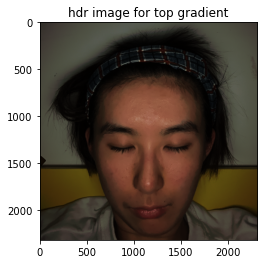

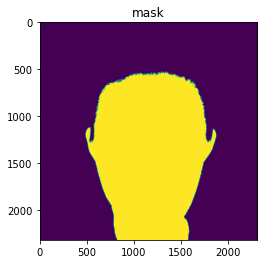

In [2]:
# Data Loading
base_addr = '/Users/tianyizuo/Desktop/Captures/final/'
up_side_down = False

def load_txt(addr):
    return pandas.read_csv(addr, header=None).to_numpy().T[:-1]

def load_folder(addr):
    mask = utils.get_heic(addr +'mask.HEIC')
    mask = np.rot90(mask, 1)
    mask = mask.repeat(2, axis=0).repeat(2, axis=1) #upsample
    mask = mask.mean(axis=-1)
    mask = (mask > 100).astype(int).astype(np.float32)
    return {
        'depth': load_txt(addr+'depth.txt'),
        'up': utils.get_hdr_image(addr + 'up')[772:],
        'down': utils.get_hdr_image(addr + 'down')[772:],
        'left': utils.get_hdr_image(addr + 'left')[772:],
        'right': utils.get_hdr_image(addr + 'right')[772:],
        'full': utils.get_hdr_image(addr + 'full')[772:],
        'mask': mask[772:],
        'mask_full':mask
    }

all_data = {
    'mid': load_folder(base_addr + "mid/"),
    'toleft': load_folder(base_addr + "toleft/"),
    'toright': load_folder(base_addr + "toright/"),
}

plt.figure()
plt.imshow(all_data['mid']['up'])
plt.title("hdr image for top gradient")

plt.figure()
plt.imshow(all_data['mid']['mask'])
plt.title("mask")


#
mask = all_data['mid']['mask']



In [3]:
#original method to estimate normal from the binary gradient paper

# X_ = all_data['mid']['left'].mean(axis=(2)) * all_data['mid']['mask']
# X = all_data['mid']['right'].mean(axis=(2)) * all_data['mid']['mask']
# Y = all_data['mid']['up'].mean(axis=(2)) * all_data['mid']['mask']
# Y_ = all_data['mid']['down'].mean(axis=(2)) * all_data['mid']['mask']



# N_mixed_xy = np.stack([X-X_, Y-Y_], axis=-1)
# N_mixed_xy /= np.linalg.norm(N_mixed_xy)

# plt.figure()
# plt.imshow((N_mixed_xy[:, :, 0] + 1)/ 2, cmap="gray")
# plt.imsave("./normal_others/nmixed_x.png", np.clip((N_mixed_xy[:, :, 0] + 1)/ 2, a_min=0, a_max=1), cmap="gray")
# plt.figure()
# plt.imshow((N_mixed_xy[:, :, 1] + 1)/ 2, cmap="gray")
# plt.imsave("./normal_others/nmixed_y.png", np.clip((N_mixed_xy[:, :, 1] + 1)/ 2, a_min=0, a_max=1), cmap="gray")

# plt.show()



In [5]:
# example of creating .obj files with landmarks
texturePaths = [base_addr+"mid/full2.HEIC", base_addr+"toleft/full2.HEIC", base_addr+"toright/full2.HEIC"]
mtlPaths = ['./out/mid.mtl', './out/toleft.mtl', './out/toright.mtl']
objPaths = ['./out/mid.obj', './out/toleft.obj', './out/toright.obj']
pickedPointsPaths =  ['./out/mid.pp', './out/toleft.pp', './out/toright.pp']
matNames = ['mid', 'toleft', 'toright']
masks = [all_data['mid']['mask_full'], all_data['toleft']['mask_full'], all_data['toright']['mask_full']]
depths = [all_data['mid']['depth'], all_data['toleft']['depth'], all_data['toright']['depth']]

landmark_3 = []
points_3 = []
ids_3 = []
location_3 = []
location_no_smooth_3 = []
ibug_3 = []
normal_3 = []

for i in range(len(texturePaths)):
    l, p, ids, location, ibug, normal, ls_ns = utils.landmark_one_object(texturePaths[i], mtlPaths[i], depths[i], objPaths[i], 
                        masks[i], pickedPointsPaths[i], matNames[i], up_side_down = up_side_down)
    landmark_3.append(l)
    points_3.append(p)
    ids_3.append(ids)
    location_3.append(location)
    ibug_3.append(ibug)
    normal_3.append(normal)
    location_no_smooth_3.append(ls_ns)


In [6]:
points_merge = [points_3[0].copy(), points_3[2].copy()]
locations_merge = [location_3[0].copy(), location_3[2].copy()]
ids_merge = [ids_3[0].copy(), ids_3[2].copy()]
matNames_merge = ["mid", "toright"]
orientation=[True, False]
texturePaths_merge =  [texturePaths[0], texturePaths[2]]
# a = utils.affine_object(points_3[1], points_3[0], location_3[1], "./out/affine_2_to_0.obj", ids_3[1])
b = utils.merge_object("./out/merge_all_ibug51.obj",  "./out/merge.mtl", points_merge, locations_merge, ids_merge, matNames_merge, texturePaths_merge, orientation)
# # b = merge_object("./out/merge_0_2_ibug51.obj",  "./out/mid_right.mtl", points_3, location_3, ids_3, matNames, texturePaths)

/Users/tianyizuo/FYP/Landmarks/utils.py:271: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A,resid,rank,sing = np.linalg.lstsq(p_from_, p_to_) #solving for least square


In [7]:
ids_right_masked = utils.mask_half_face(ibug_3[2], ids)
ids_merge_masked = [ids_3[0], ids_right_masked]
utils.merge_object("./out/merge_0_2_ibug51_half.obj",  "./out/mid_right_half.mtl", points_merge, locations_merge, ids_merge_masked, matNames_merge, texturePaths_merge, orientation)

array([[[[ 0.27940082,  0.20978962, -0.52188942,  1.        ],
         [ 0.27861312,  0.20985651, -0.52205582,  1.        ],
         [ 0.2778966 ,  0.20997761, -0.52235709,  1.        ],
         ...,
         [-0.13577046,  0.20536911, -0.5108926 ,  1.        ],
         [-0.13659862,  0.20532419, -0.51078087,  1.        ],
         [-0.13744039,  0.20530018, -0.51072113,  1.        ]],

        [[ 0.27942676,  0.20893251, -0.52193788,  1.        ],
         [ 0.27863926,  0.20899933, -0.5221048 ,  1.        ],
         [ 0.27792312,  0.20912027, -0.52240693,  1.        ],
         ...,
         [-0.13577401,  0.20451641, -0.51090595,  1.        ],
         [-0.13660239,  0.20447199, -0.51079498,  1.        ],
         [-0.13744429,  0.20444823, -0.51073561,  1.        ]],

        [[ 0.2794749 ,  0.20809176, -0.52202779,  1.        ],
         [ 0.27868778,  0.2081587 , -0.52219572,  1.        ],
         [ 0.27797238,  0.2082798 , -0.52249952,  1.        ],
         ...,
         

In [8]:
I, size = utils.get_input(all_data['mid'])
normal_depth = normal_3[0]
print(normal_depth.shape)

(640, 480, 3)


(5363856, 4)


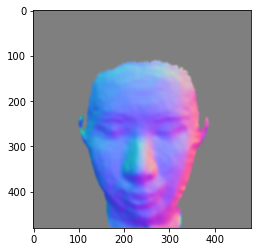

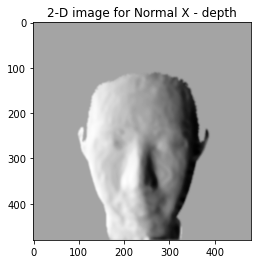

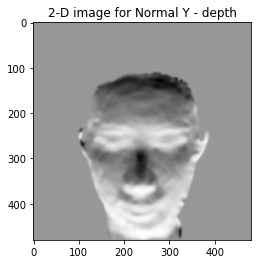

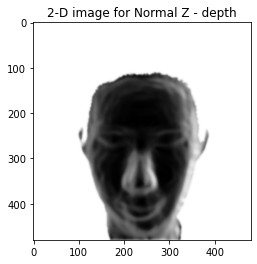

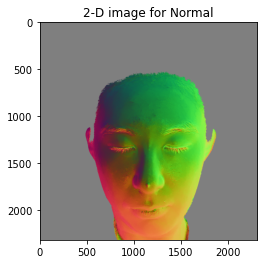

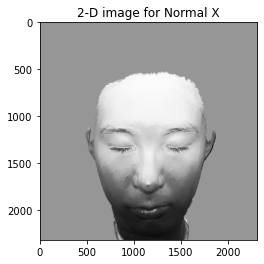

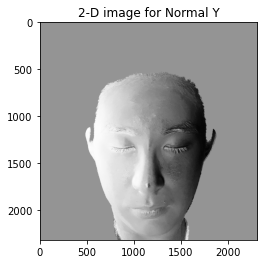

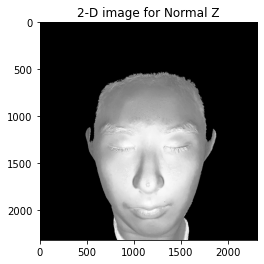

/Users/tianyizuo/FYP/Landmarks/utils.py:484: RuntimeWarning: invalid value encountered in true_divide
  normal_corrected /= np.linalg.norm(normal_corrected, axis=-1).reshape(normal_corrected.shape[0], normal_corrected.shape[1], 1)


(2316, 2316, 3)


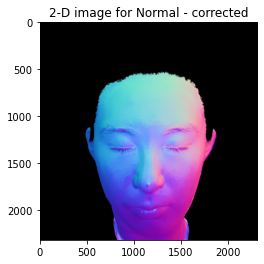

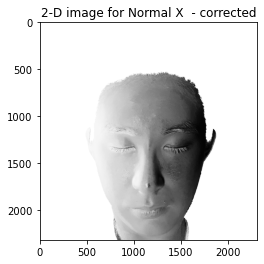

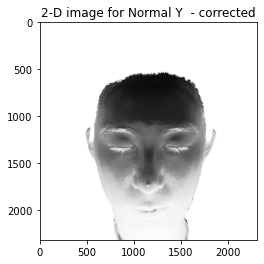

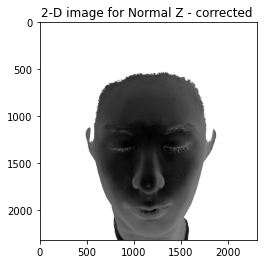

In [9]:
normal_corrected = utils.surface_normal_correction(I, [2316, 2316] , all_data['mid']['mask'], normal_depth[int(772. * 640. /3088.):])

(5363856, 4)
(2316, 2316, 3)


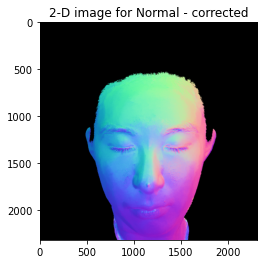

(5363856, 4)
(2316, 2316, 3)


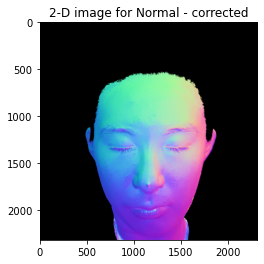

(5363856, 4)
(2316, 2316, 3)


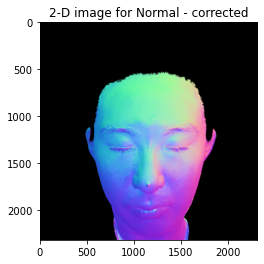

(5363856, 4)
(2316, 2316, 3)


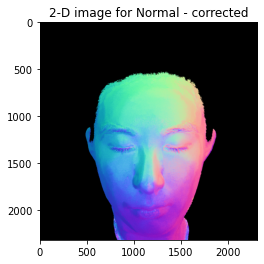

<ipython-input-10-6bdb620353eb>:22: RuntimeWarning: invalid value encountered in true_divide
  normal_diffuse /= np.stack([np.linalg.norm(normal_diffuse, axis=-1)]*3, axis=-1)


In [10]:
# variation of svds:
I_red, size_red = utils.get_input(all_data['mid'], "R")
I_green, size_green = utils.get_input(all_data['mid'], "G")
I_blue, size_blue = utils.get_input(all_data['mid'], "B")

normal_red = utils.surface_normal_correction(I_red, size_red, all_data['mid']['mask'], normal_depth, False)
normal_green = utils.surface_normal_correction(I_green, size_green, all_data['mid']['mask'], normal_depth, False)
normal_blue = utils.surface_normal_correction(I_blue, size_blue, all_data['mid']['mask'], normal_depth, False)

plt.imsave("./colorspace/normal_red.png", np.clip((normal_red + 1)/2, a_min=0, a_max=1))
plt.imsave("./colorspace/normal_green.png", np.clip((normal_green + 1)/2, a_min=0, a_max=1))
plt.imsave("./colorspace/normal_blue.png", np.clip((normal_blue + 1)/2, a_min=0, a_max=1))


normal_diffuse = utils.surface_normal_correction(I_red - 0.9 * I_blue, size_blue, all_data['mid']['mask'], normal_depth, False)
where_are_NaNs = np.isnan(normal_diffuse)
normal_diffuse[where_are_NaNs] = 0
where_are_infs = np.isposinf(normal_diffuse)
normal_diffuse[where_are_infs] = 1
where_are_neginfs = np.isneginf(normal_diffuse)
normal_diffuse[where_are_neginfs] = -1
normal_diffuse /= np.stack([np.linalg.norm(normal_diffuse, axis=-1)]*3, axis=-1)
plt.imsave("./colorspace/normal_R-0.8B.png", np.clip((normal_diffuse + 1)/2, a_min=0, a_max=1))
        

In [11]:
#Create plyfile for mesh_opt application
utils.create_ply(normal_red, all_data['mid']['full'], location_no_smooth_3[0], "./mid.ply")


0.7024433


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


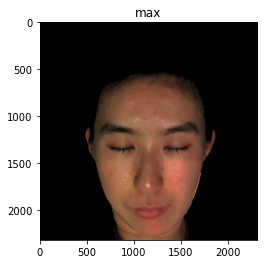

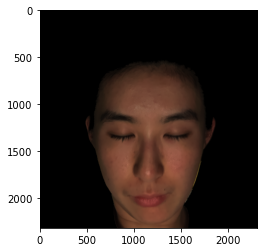

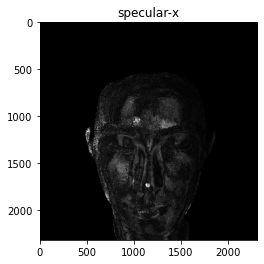

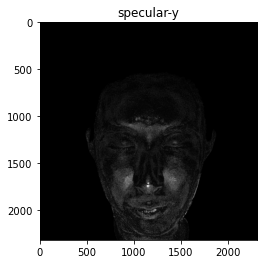

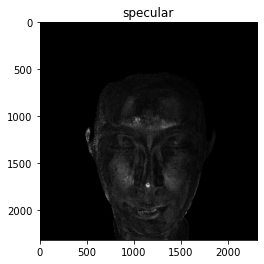

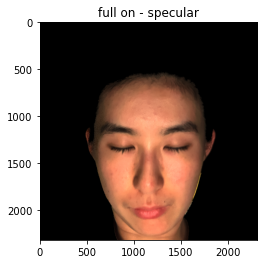

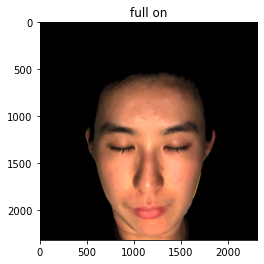

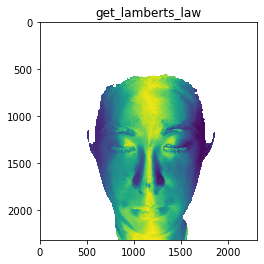

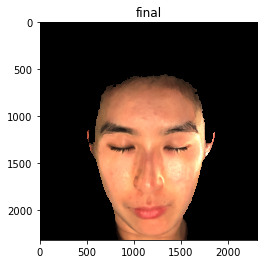

In [12]:
mask_3 = np.stack([all_data['mid']['mask'], all_data['mid']['mask'], all_data['mid']['mask']], axis = 2)
down = np.clip(all_data['mid']['down'] * mask_3, 0, 1)
up = np.clip(all_data['mid']['up'] * mask_3, 0, 1)
left = np.clip(all_data['mid']['left'] * mask_3, 0, 1)
right = np.clip(all_data['mid']['right'] * mask_3, 0, 1)

all_pics = np.stack([down, up, left, right], axis=-1)
full = (up + down + left + right)/2
max_all = all_pics.max(axis=-1)
min_all = all_pics.mean(axis=-1)
ambient = min_all[mask.astype(bool)].mean()/max_all[mask.astype(bool)].mean()
print(ambient)
plt.figure()
plt.imshow(max_all, cmap = "gray")
plt.title("max")

plt.figure()
plt.imshow(min_all, cmap = "gray")

    
rgbs = [down, up, left, right]
hsvs = []
for rgb in rgbs:
    hsvs.append(cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV))
chromas = []
for rgb in rgbs:
    M = np.max(rgb, axis=2)
    m = np.min(rgb, axis=2)
    chromas.append(M-m)
y, y_, x, x_ = hsvs
ychroma, ychroma_, xchroma, xchroma_ = chromas
eps = 1e-3
delta_y = y[:, :, 2] - ychroma/(y_[:, :, 1] + eps)
delta_x = x[:, :, 2] - xchroma/(x_[:, :, 1] + eps)
specular_x = np.abs(delta_x)
specular_y = np.abs(delta_y)

def visualize_specular_albedo(specular):
    return (utils.min_max_normalization(specular.clip(0, 0.2) * 5)).astype(np.float32)

plt.figure()
plt.imshow(visualize_specular_albedo(specular_x), cmap = "gray")
plt.title("specular-x")
cv2.imwrite("./shadow_remove/specular_x.hdr",  np.clip(cv2.cvtColor(specular_x, cv2.COLOR_RGB2BGR), 0, 1))

plt.figure()
plt.imshow(visualize_specular_albedo(specular_y), cmap = "gray")
plt.title("specular-y")
cv2.imwrite("./shadow_remove/specular_y.hdr",  np.clip(cv2.cvtColor(specular_y, cv2.COLOR_RGB2BGR), 0, 1))

total_specular = (specular_x + specular_y)/2
plt.figure()
plt.imshow(visualize_specular_albedo(total_specular), cmap = "gray")
plt.title("specular")
cv2.imwrite("./shadow_remove/total_specular.hdr",  np.clip(cv2.cvtColor(total_specular, cv2.COLOR_RGB2BGR), 0, 1))
speculars = np.stack([total_specular] * 3, axis = 2)


where_are_NaNs = np.isnan(speculars)
speculars[where_are_NaNs] = 0
where_are_infs = np.isposinf(speculars)
speculars[where_are_infs] = 1
where_are_neginfs = np.isneginf(speculars)
speculars[where_are_neginfs] = 0

diffuse_albedo = full - speculars

plt.figure()
plt.imshow(diffuse_albedo)
plt.title("full on - specular")

pickle.dump(diffuse_albedo, open('./albedo.p', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

plt.figure()
plt.imshow(full)
plt.title("full on")
cv2.imwrite("./shadow_remove/full.hdr",  np.clip(cv2.cvtColor(utils.gamma_correction(full, gamma = 1), cv2.COLOR_RGB2BGR), 0, 1))
cv2.imwrite("./shadow_remove/diffuse_albedo.hdr",  np.clip(cv2.cvtColor(utils.gamma_correction(diffuse_albedo, gamma = 1), cv2.COLOR_RGB2BGR), 0, 1))


diffuse_albedo_corrected = diffuse_albedo.copy()
normal = normal_red #cv2.resize(normal_depth.copy(), dsize=(diffuse_albedo.shape[1], diffuse_albedo.shape[0]))
illumination = np.asarray([1., 0., 0.])
get_lamberts_law = 1 - np.abs(np.clip(np.dot(normal, illumination), -1.0, 1.0))


plt.figure()
plt.imshow(get_lamberts_law)
plt.title("get_lamberts_law")

lambert_separation = np.stack([get_lamberts_law, get_lamberts_law, get_lamberts_law], axis = -1)
diffuse_albedo_corrected /= lambert_separation
cv2.imwrite("./shadow_remove/divide_by_get_lambert.hdr",  np.clip(cv2.cvtColor(utils.gamma_correction(diffuse_albedo_corrected, gamma = 1), cv2.COLOR_RGB2BGR), 0, 1))

alpha = 0.2
diffuse_albedo_corrected = alpha *  diffuse_albedo_corrected + diffuse_albedo * (1 - alpha)
specular_corrected = alpha *  speculars/lambert_separation + speculars * (1 - alpha)
cv2.imwrite('./shadow_remove/specular_corrected.hdr', np.clip(cv2.cvtColor(specular_corrected.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
plt.figure()
plt.imshow(diffuse_albedo_corrected)
plt.title("final")
cv2.imwrite('./shadow_remove/final.hdr', np.clip(cv2.cvtColor(diffuse_albedo_corrected, cv2.COLOR_RGB2BGR), 0, 1))

plt.show()

In [13]:
#using rendered sphere from Maya to solve the lighting problem - did not work well

# mask = all_data['mid']['mask']
# normal = np.clip(normal.copy(), -1, 1) + 1e-3
# diffuse_albedo_corrected_sim = diffuse_albedo.copy()
# illu = utils.min_max_normalization(cv2.imread('./illu.jpg'))
# plt.figure()
# plt.imshow(illu)
# plt.title("ipad illumination on diffuse sphere")
# plt.show()

# length = illu.shape[0] - 1
# # diffuse_albedo_corrected_sim = cv2.cvtColor(diffuse_albedo_corrected_sim, cv2.COLOR_RGB2HSV)
# for i in range(2316):
#     for j in range(2316):
#         if mask[i, j] > 0:
#             n = normal[i, j]
#             diffuse_albedo_corrected_sim[i, j] /= illu[int((n[1] + 1)/2 * length), 
#                                                        int((n[0] + 1)/2 * length)].max()
            
# # diffuse_albedo_corrected_sim = cv2.cvtColor(diffuse_albedo_corrected_sim, cv2.COLOR_HSV2RGB)
            
# plt.figure()
# plt.imshow(diffuse_albedo_corrected_sim)
# plt.title("final sim")
# plt.imsave("./shadow_remove/final_sim.png", np.clip(diffuse_albedo_corrected_sim, 0, 1))

# # diffuse_albedo_corrected_sim /= np.stack([get_lamberts_law, get_lamberts_law, get_lamberts_law], axis = -1)
# alpha = 0.3
# diffuse_albedo_corrected_sim = alpha *  diffuse_albedo_corrected_sim + diffuse_albedo * (1 - alpha)
# cv2.imwrite('./shadow_remove/final_sim.hdr', np.clip(cv2.cvtColor(diffuse_albedo_corrected_sim, cv2.COLOR_RGB2BGR), 0, 1))
# plt.figure()
# plt.imshow(diffuse_albedo_corrected_sim)
# plt.title("final sim alpha")
# plt.imsave("./shadow_remove/final_sim.png", np.clip(diffuse_albedo_corrected_sim, 0, 1))
# plt.show()

In [14]:
# s, g = utils.get_specular_and_matt(all_data['mid']['full'], all_data['mid']['mask'])

In [15]:
# Nuv = utils.normal_from_uv(all_data['mid'], normal_depth)

In [16]:
# plt.imsave("./colorspace/hdr.png", np.clip((Nuv + 1)/2, a_min=0, a_max=1))

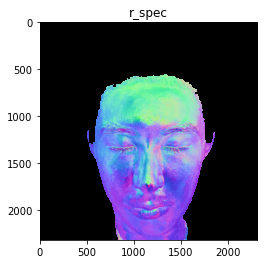

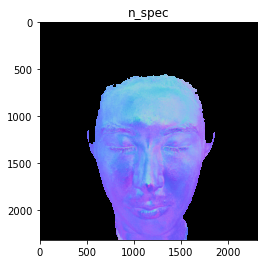

<ipython-input-17-73f90cfde0be>:41: RuntimeWarning: invalid value encountered in true_divide
  n_spec_final /= np.linalg.norm(n_spec_final, axis=-1).reshape(n_spec_final.shape[0], n_spec_final.shape[1], 1)


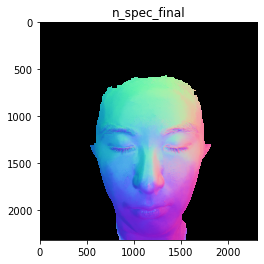

In [17]:
# Specular normal
masked_diffuse = diffuse_albedo[all_data['mid']['mask'].astype(bool)]
masked_full = full[all_data['mid']['mask'].astype(bool)]
alpha_1D = np.divide(masked_diffuse, masked_full)
alpha = np.zeros(diffuse_albedo.shape)
alpha[all_data['mid']['mask'].astype(bool)]= alpha_1D

r_spec = normal_blue - 0.8 * alpha * cv2.GaussianBlur(utils.replaceNan(normal_diffuse),(21, 21),0)
r_spec /= np.linalg.norm(r_spec, axis = -1).reshape(r_spec.shape[0], r_spec.shape[1], 1)

viewing_direction = np.asarray([0, 0, 1]) # how to find this v ?

n_spec = r_spec + viewing_direction
n_spec /= np.linalg.norm(n_spec, axis = -1).reshape(n_spec.shape[0], n_spec.shape[1], 1)

rspec_print = np.clip((r_spec + 1)/ 2, 0, 1)
nspec_print = np.clip((n_spec + 1)/ 2, 0, 1)

cv2.imwrite('./shadow_remove/rspec_print.hdr', np.clip(cv2.cvtColor(rspec_print.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))

cv2.imwrite('./shadow_remove/nspec_print.hdr', np.clip(cv2.cvtColor(nspec_print.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))


plt.figure()
plt.imshow(rspec_print)
plt.imsave("./normals/r_spec.png", rspec_print)
plt.title("r_spec")

plt.figure()
plt.imshow(nspec_print)
plt.imsave("./normals/n_spec.png", nspec_print)
plt.title("n_spec")

plt.show()
# nspec_print = cv2.fastNlMeansDenoisingColored(np.uint8(nspec_print*255),None,5,5,7,21)
# cv2.imwrite('./shadow_remove/nspec_print_smooth.hdr', np.clip(cv2.cvtColor(nspec_print.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
# plt.imsave("./normals/n_spec_smoothed.png", nspec_print)

n_spec_final = n_spec - 0.9 * cv2.GaussianBlur(n_spec,(21, 21),0) + normal_diffuse
n_spec_final = utils.replaceNan(n_spec_final)
n_spec_final /= np.linalg.norm(n_spec_final, axis=-1).reshape(n_spec_final.shape[0], n_spec_final.shape[1], 1)
n_spec_final_print = np.clip((n_spec_final + 1)/ 2, 0, 1)
plt.figure()
plt.imshow(n_spec_final_print)
plt.imsave("./normals/n_spec_final.png", n_spec_final_print)
plt.title("n_spec_final")

plt.show()


In [18]:
#Equation. 7. No color for the X axis. blue for horizontal and red for vertical
# blurred_normal = utils.replaceNan(cv2.resize(normal_depth.copy(), dsize = (2316, 3088)))[772:]
blurred_normal = utils.replaceNan(normal_blue.copy())
blurred_normal = (blurred_normal + 1)/2
blurred_normal /= np.stack([np.linalg.norm(blurred_normal, axis=-1)]*3, axis=-1)

print(np.any(np.isnan(blurred_normal)))

g_x = all_data['mid']['right'].mean(axis=-1)* mask.astype(float)
c_x = all_data['mid']['left'].mean(axis=-1) * mask.astype(float)
Nd_x = np.clip(blurred_normal[:, :, 0], 0, 1)
print(Nd_x.max())
print(Nd_x.min())

g_y = all_data['mid']['up'].mean(axis=-1) * mask.astype(float)
c_y = all_data['mid']['down'].mean(axis=-1) * mask.astype(float)
Nd_y = np.clip(blurred_normal[:, :, 1], 0, 1)
print(Nd_y.max())
print(Nd_y.min())

def solve_spectral(A, B, Nd):
    All = np.stack([A, B], axis= -1)
    G = All.max(axis=-1)
    C = All.min(axis=-1)
    S = (G*(1-Nd) - C*Nd)/(1-Nd)
    return np.clip(S, 0, None)

spec_x = solve_spectral(g_x, c_x, Nd_x) 
spec_y = solve_spectral(g_y, c_y, Nd_y) 
spec_both = (spec_x + spec_y)/4
# spec_both = utils.min_max_normalization(spec_both)
print(spec_both.max())

# print(spec_both.shape)

diffuse_albedo_ls = full - np.stack([spec_both]*3, axis=-1)
cv2.imwrite("./shadow_remove/diffuse_ls.hdr",  np.clip(cv2.cvtColor(diffuse_albedo_ls.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
cv2.imwrite("./shadow_remove/ls_specular.hdr",  np.clip(cv2.cvtColor(spec_both.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
cv2.imwrite("./shadow_remove/ls_specular_scale.hdr",  np.clip(cv2.cvtColor(0.06*spec_both.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))

False
0.8022412775428103
0.054400514630802484
0.8174489179889189
0.04877680400997366
0.23463286042957288


True

In [19]:
## using the surface normal, create directional
def get_lambert(direction, normal):
    get_lamberts_law = np.clip(np.dot(normal, direction), 0, None)
    get_lambert_3 = (np.stack([get_lamberts_law, get_lamberts_law, get_lamberts_law], axis=-1))
    return get_lambert_3

#for specular
def phong_relighting(locations, light_direction, normals, specular_albedo, s=2):
    w = normals.shape[1]
    h = normals.shape[0]
#     light_direction /= np.linalg.norm(light_direction)
    light_direction = np.tile(light_direction.reshape((1, 1, 3)), (h, w, 1))
    camera_position = np.asarray([0, (ipad_width_pixel/pixel_per_meter)/2, 0])
    camera_position = np.tile(camera_position.reshape((1, 1, 3)), (h, w, 1))
    r = 2*(np.einsum('ijk,ijk->ij',normals, light_direction)).reshape((h, w, 1)) * normals - normals
    r /= np.linalg.norm(r, axis = -1).reshape(h, w, 1)
    o = locations - camera_position
    o /= np.linalg.norm(o, axis = -1).reshape(h, w, 1)  
    cos_theta = np.einsum('ijk,ijk->ij',r,o)
    cos_theta = np.power(cos_theta, s)
    n_dot_i = np.einsum('ijk,ijk->ij',normals, light_direction)
    f = np.clip(specular_albedo * (cos_theta/n_dot_i).reshape((h, w, 1)), 0, 1)
    return f

def get_lambert_point_light(point, normal, locations):
    point = np.tile(point.reshape((1, 1, 3)), (normal.shape[0], normal.shape[1], 1))
    directions = point - locations
    get_lamberts_law = np.clip(np.einsum('ijk,ijk->ij',normal,directions), 0, None)
    get_lambert_3 = (np.stack([get_lamberts_law, get_lamberts_law, get_lamberts_law], axis=-1))
    return get_lambert_3

#for specular
def phong_relighting_point_light(locations, point_light, normals, specular_albedo, s=2):
    w = normals.shape[1]
    h = normals.shape[0]
    point_light = np.tile(point_light.reshape((1, 1, 3)), (h, w, 1))
    light_direction = -point_light + locations
    camera_position = np.asarray([0, (ipad_width_pixel/pixel_per_meter)/2, 0])
    camera_position = np.tile(camera_position.reshape((1, 1, 3)), (h, w, 1))
    r = 2*(np.einsum('ijk,ijk->ij',normals, light_direction)).reshape((h, w, 1)) * normals - normals
    r /= np.linalg.norm(r, axis = -1).reshape(h, w, 1)
    o = locations - camera_position
    o /= np.linalg.norm(o, axis = -1).reshape(h, w, 1)  
    cos_theta = np.einsum('ijk,ijk->ij',r,o)
    cos_theta = np.power(cos_theta, s)
    n_dot_i = np.einsum('ijk,ijk->ij',normals, light_direction)
    f = np.clip(specular_albedo * (cos_theta/n_dot_i).reshape((h, w, 1)), 0, 1)
    return f

def mosaic_latlong(latlong, bin_size):
    print(bin_size)
    h, w = bin_size
    h = int(latlong.shape[0]/h)
    w = int(latlong.shape[1]/w)
    latlong_mosaic = latlong.copy()
    numerical = np.zeros((bin_size[0], bin_size[1], 3))
    for i in range (0, latlong.shape[0] - int(0.5 * h), h):
        for j in range(0, latlong.shape[1] - int(0.5 * w), w):
            average_energy = latlong[i:i+h, j:j+w].mean(axis=(0, 1))
            latlong_mosaic[i:i+h, j:j+w] = average_energy
            numerical[int(i/h), int(j/w)] = average_energy
    # make the total amount of energy 1
    numerical_sum = numerical.sum(axis=(0, 1)).mean()
    return latlong_mosaic, numerical/numerical_sum

def get_reflectance_field(latlong_shape, bin_size, normal_diffuse, albedo, locations, normal_specular, albedo_specular):
    h, w = bin_size
    h = int(latlong_shape[0]/h)
    w = int(latlong_shape[1]/w)
    reflectance_field_diffuse = np.zeros((bin_size[0], bin_size[1], albedo.shape[0], albedo.shape[1], 3))
    reflectance_field_specular = np.zeros((bin_size[0], bin_size[1], albedo.shape[0], albedo.shape[1], 3))
    reflectance_field_compensate = np.zeros((albedo.shape[0], albedo.shape[1], 1))
    for i in range (0, latlong_shape[0] - int(0.5 * h), h): #hack to solve numerical values
        for j in range(0, latlong_shape[1] - int(0.5 * w), w):
            latlong_coord = ((i + 0.5 * h)/latlong_shape[0], (j + 0.5 * w)/latlong_shape[1])
            cartesian, compensate = latlong_to_cartesian(latlong_coord[0], latlong_coord[1])
            cartesian /= np.linalg.norm(cartesian)
            get_lambert_3 = get_lambert(cartesian, normal_diffuse)
            d = get_lambert_3 * albedo
            s = phong_relighting(locations, cartesian, normal_specular, albedo_specular) * get_lambert_3
            c = np.abs(compensate)
            reflectance_field_diffuse[int(i/h), int(j/w)] = d
            reflectance_field_specular[int(i/h), int(j/w)] = s
            reflectance_field_compensate[int(i/h), int(j/w)] = c
#             cv2.imwrite('./reflectance_field/d'+str(cartesian)+'.hdr', np.clip(cv2.cvtColor(d.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
#             cv2.imwrite('./reflectance_field/s'+str(cartesian)+'.hdr', np.clip(cv2.cvtColor(s.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
#             cv2.imwrite('./reflectance_field/'+str(cartesian)+'.hdr', np.clip(cv2.cvtColor((s + d).astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
    return reflectance_field_diffuse, reflectance_field_specular, reflectance_field_compensate
    
def cartesian_to_latlong(c, height, width):
    #https://stackoverflow.com/questions/5674149/3d-coordinates-on-a-sphere-to-latitude-and-longitude
    latlong_idx = np.zeros(2, dtype=float)
    theta = (np.arccos(c[1]) / np.pi)
    phi = (np.arctan2(c[2], c[0]) / np.pi + 0.5)/2
    latlong_idx[0] = theta * (height - 1)
    # latlong_idx[1] = (1 - phi)%1 * (width - 1)
    latlong_idx[1] = phi * (width - 1)
    return latlong_idx.astype(int)

def latlong_to_cartesian(latlong_x, latlong_y):
    theta = latlong_x*math.pi
    phi = latlong_y*math.pi*2 - 0.5*math.pi
#     print(theta, phi)
    return np.asarray([
         math.sin(theta) * math.cos(phi),
         math.cos(theta),
         math.sin(theta) * math.sin(phi)
    ]), math.sin(theta)

def visualize_reflectance_field(reflectance_field):
    h_out, w_out, h, w, _ = reflectance_field.shape
    h_small = 100
    w_small = int(w/(h/h_small))
    visualize_field = np.zeros((h_small*h_out, w_small*w_out, 3))
    for i in range(h_out):
        for j in range(w_out):      
            visualize_field[i*h_small: (i+1)*h_small, j*w_small: (j+1)*w_small] =  cv2.resize(
                reflectance_field[i, j], dsize=(w_small, h_small), interpolation=cv2.INTER_CUBIC)
#     cv2.imwrite('./relighting/visualize_field.hdr', np.clip(cv2.cvtColor(visualize_field, cv2.COLOR_RGB2BGR), 0, 1))
    return visualize_field

# #create fake image based relighting
def relight_with_probe(latlong, da, sa, normal_diffuse, normal_specular, locations, bin_size=(10, 16)):
    #Diffuse 
    incident_light_field, ilf_array = mosaic_latlong(latlong, bin_size)
    plt.figure()
    plt.imshow(incident_light_field)
    plt.title("grace cathedral lat long map divided into bins")
    plt.show()
    d, s, c = get_reflectance_field(latlong.shape, bin_size, normal_diffuse, da, locations, normal_specular, sa)
    vf = visualize_reflectance_field(d)
    
    plt.figure(figsize = (10,20))
    plt.imshow(vf)
    plt.title("reflectance field")
    plt.show()
    final_d = np.zeros(da.shape)
    final_s = np.zeros(da.shape)
    for i in range(bin_size[0]):
        for j in range(bin_size[1]):  
            final_d += d[i, j]* c[i, j] * ilf_array[i, j]
            final_s += s[i, j]* c[i, j] * ilf_array[i, j] 
    final_d = np.clip(final_d, 0, 1)
    final_s = np.clip(final_s, 0, 1)
    plt.figure()
    plt.imshow(final_d + final_s)
    plt.title("relighting")
    plt.show()    
    
    return final_d, final_s, final_d + final_s
    
    
    

In [20]:
mask = all_data['mid']['mask']
normal = np.clip(normal_diffuse.copy(), -1, 1)
da = diffuse_albedo_ls.copy()
sa = specular_corrected.copy()
#for speculars
light_probe = utils.min_max_normalization(cv2.cvtColor(cv2.imread('./grace_probe.hdr'), cv2.COLOR_RGB2BGR))
#for diffuse
lat_long = utils.min_max_normalization(cv2.cvtColor(cv2.imread('./grace_latlong.hdr'), cv2.COLOR_RGB2BGR))
locations = cv2.resize(location_3[0].astype('float32'), dsize=(int(ipad_width_pixel), int(ipad_height_pixel)))[772:]
light = np.asarray([1., 0., 0.])
s=2.5
p = phong_relighting_point_light(locations, light, n_spec_final, sa, s=s)
lambert = get_lambert_point_light(light, normal, locations)
p = utils.replaceNan(p)
total = (p + da) * lambert + da * 0.05
cv2.imwrite('./relighting/point'+str(s)+"_"+str(light)+'.hdr', np.clip(cv2.cvtColor(total.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))


<ipython-input-19-cd9cffda0516>:45: RuntimeWarning: invalid value encountered in power
  cos_theta = np.power(cos_theta, s)


True

(10, 16)


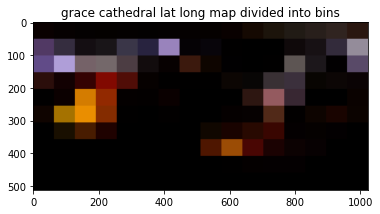

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


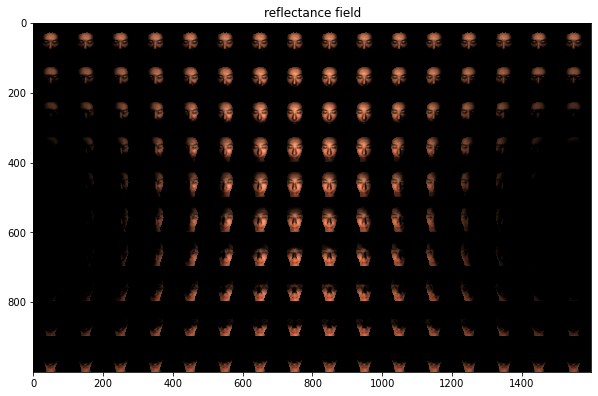

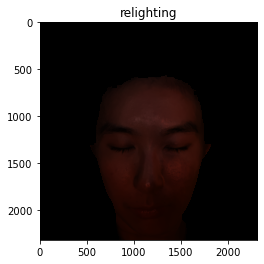

In [21]:
#simple image based relighting
mask = all_data['mid']['mask']
normal = np.clip(cv2.GaussianBlur(normal_diffuse.copy(),(11, 11),0), -1, 1) + 1e-3
da = diffuse_albedo_ls.copy()
sa = specular_corrected.copy()
#for speculars
light_probe = utils.min_max_normalization(cv2.cvtColor(cv2.imread('./grace_probe.hdr'), cv2.COLOR_RGB2BGR))
#for diffuse
lat_long = utils.min_max_normalization(cv2.cvtColor(cv2.imread('./grace_latlong.hdr'), cv2.COLOR_RGB2BGR))
locations = cv2.resize(location_3[0].astype('float32'), dsize=(int(ipad_width_pixel), int(ipad_height_pixel)))[772:]

diffuse_final, specular_final, total_final = relight_with_probe(lat_long, da, sa, normal_red, n_spec_final, locations)

In [22]:
cv2.imwrite("./relighting/total_final.hdr",  np.clip(cv2.cvtColor(total_final.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
cv2.imwrite("./relighting/diffuse_final.hdr",  np.clip(cv2.cvtColor(diffuse_final.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
cv2.imwrite("./relighting/specular_final.hdr",  np.clip(cv2.cvtColor(specular_final.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))



True

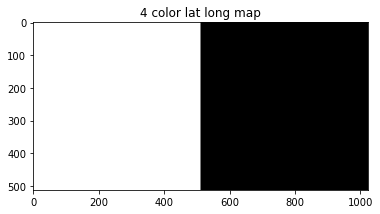

(10, 16)


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [23]:
#for diffuse
#simple image based relighting
mask = all_data['mid']['mask']
normal = np.clip(cv2.GaussianBlur(normal_diffuse.copy(),(11, 11),0), -1, 1) + 1e-3
da = diffuse_albedo_ls.copy()
sa = specular_corrected.copy()
#for speculars
light_probe = utils.min_max_normalization(cv2.cvtColor(cv2.imread('./grace_probe.hdr'), cv2.COLOR_RGB2BGR))
#for diffuse
lat_long = utils.min_max_normalization(cv2.cvtColor(cv2.imread('./grace_latlong.hdr'), cv2.COLOR_RGB2BGR))
locations = cv2.resize(location_3[0].astype('float32'), dsize=(int(ipad_width_pixel), int(ipad_height_pixel)))[772:]

lat_long_rgb = np.zeros((512, 1024, 3))
lat_long_rgb[:, :512] = np.asarray([1, 1, 1])
plt.figure()
plt.imshow(lat_long_rgb)
plt.title("4 color lat long map")
plt.imsave('./relighting/half.jpg', lat_long_rgb)

plt.show()

diffuse_final_rgb, specular_final_rgb, total_final_rgb = relight_with_probe(lat_long_rgb, da, sa, normal_red, n_spec, locations)

In [ ]:
cv2.imwrite("./relighting/total_final_rgb.hdr",  np.clip(cv2.cvtColor(total_final_rgb.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
cv2.imwrite("./relighting/diffuse_final_rgb.hdr",  np.clip(cv2.cvtColor(diffuse_final_rgb.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
cv2.imwrite("./relighting/specular_final_rgb.hdr",  np.clip(cv2.cvtColor(specular_final_rgb.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))

In [ ]:
# objPath = '/Users/tianyizuo/FYP/Landmarks/out/mid_novt.obj'
# mtlPath = '/Users/tianyizuo/FYP/Landmarks/out/mid_novt.mtl'
# utils.create_obj(all_data['mid']['depth'], objPath, mtlPath, "nomat", all_data['mid']['mask'], useMaterial = False, up_side_down = False, no_vt= True)


In [ ]:
#for diffuse
#simple image based relighting
mask = all_data['mid']['mask']
normal = np.clip(cv2.GaussianBlur(normal_diffuse.copy(),(11, 11),0), -1, 1) + 1e-3
da = diffuse_albedo_ls.copy()
sa = specular_corrected.copy()
#for speculars
light_probe = utils.min_max_normalization(cv2.cvtColor(cv2.imread('./grace-new.hdr'), cv2.COLOR_RGB2BGR))
#for diffuse
lat_long = utils.min_max_normalization(cv2.cvtColor(cv2.imread('./grace-new.hdr'), cv2.COLOR_RGB2BGR))
locations = cv2.resize(location_3[0].astype('float32'), dsize=(int(ipad_width_pixel), int(ipad_height_pixel)))[772:]

diffuse_final_rgb, specular_final_rgb, total_final_rgb = relight_with_probe(lat_long, da, sa, normal_red, n_spec, locations)
cv2.imwrite("./relighting/total_final_grace-new.hdr",  np.clip(cv2.cvtColor(total_final_rgb.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
cv2.imwrite("./relighting/diffuse_final_grace-new.hdr",  np.clip(cv2.cvtColor(diffuse_final_rgb.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
cv2.imwrite("./relighting/specular_final_grace-new.hdr",  np.clip(cv2.cvtColor(specular_final_rgb.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))

In [ ]:
#for diffuse
#simple image based relighting
mask = all_data['mid']['mask']
normal = np.clip(cv2.GaussianBlur(normal_diffuse.copy(),(11, 11),0), -1, 1) + 1e-3
da = diffuse_albedo_ls.copy()
sa = specular_corrected.copy()
#for speculars
light_probe = utils.min_max_normalization(cv2.cvtColor(cv2.imread('./pisa.hdr'), cv2.COLOR_RGB2BGR))
#for diffuse
lat_long = utils.min_max_normalization(cv2.cvtColor(cv2.imread('./pisa.hdr'), cv2.COLOR_RGB2BGR))
locations = cv2.resize(location_3[0].astype('float32'), dsize=(int(ipad_width_pixel), int(ipad_height_pixel)))[772:]

diffuse_final_rgb, specular_final_rgb, total_final_rgb = relight_with_probe(lat_long, da, sa, normal_red, n_spec, locations)
cv2.imwrite("./relighting/total_final_pisa.hdr",  np.clip(cv2.cvtColor(total_final_rgb.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
cv2.imwrite("./relighting/diffuse_final_pisa.hdr",  np.clip(cv2.cvtColor(diffuse_final_rgb.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
cv2.imwrite("./relighting/specular_final_pisa.hdr",  np.clip(cv2.cvtColor(specular_final_rgb.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))

In [ ]:
#for diffuse
#simple image based relighting
mask = all_data['mid']['mask']
normal = np.clip(cv2.GaussianBlur(normal_diffuse.copy(),(11, 11),0), -1, 1) + 1e-3
da = diffuse_albedo_ls.copy()
sa = specular_corrected.copy()
#for speculars
light_probe = utils.min_max_normalization(cv2.cvtColor(cv2.imread('./doge2.hdr'), cv2.COLOR_RGB2BGR))
#for diffuse
lat_long = utils.min_max_normalization(cv2.cvtColor(cv2.imread('./doge2.hdr'), cv2.COLOR_RGB2BGR))
locations = cv2.resize(location_3[0].astype('float32'), dsize=(int(ipad_width_pixel), int(ipad_height_pixel)))[772:]

diffuse_final_rgb, specular_final_rgb, total_final_rgb = relight_with_probe(lat_long, da, sa, normal_red, n_spec, locations)
cv2.imwrite("./relighting/total_final_doge2.hdr",  np.clip(cv2.cvtColor(total_final_rgb.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
cv2.imwrite("./relighting/diffuse_final_doge2.hdr",  np.clip(cv2.cvtColor(diffuse_final_rgb.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))
cv2.imwrite("./relighting/specular_final_doge2.hdr",  np.clip(cv2.cvtColor(specular_final_rgb.astype(np.float32), cv2.COLOR_RGB2BGR), 0, 1))